In [9]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf
#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
#import classifiers
#import Ensemble Trees Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import xgboost as xgb
#to save model fit with GridSearchCV and avoid longer waits
import joblib

In [10]:
###########################################################################
#  Explainability Analisys
# The "most explainable" classifier is ExtraTrees by assessing the FIR ratio
# Different explainability method are considered: implicit feature importance, feature permutation, SHAP and PDP
###########################################################################
#Loading the dataset
path_data=r'heart_failure_clinical_records_dataset.csv'
df=pd.read_csv(path_data)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [11]:
target_feature='DEATH_EVENT'
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
df=adhoc_transf.ageRounder().fit_transform(df)
my_utils.df_values(df)


>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder
*****start of feature  age *************************
age
60.0    33
50.0    27
65.0    26
70.0    25
45.0    19
55.0    17
75.0    11
58.0    10
53.0    10
63.0     8
42.0     7
40.0     7
72.0     7
80.0     7
61.0     6
85.0     6
52.0     5
68.0     5
62.0     5
49.0     4
59.0     4
73.0     4
51.0     4
64.0     3
46.0     3
69.0     3
82.0     3
90.0     3
66.0     2
78.0     2
54.0     2
77.0     2
57.0     2
44.0     2
67.0     2
95.0     2
48.0     2
43.0     1
86.0     1
81.0     1
79.0     1
41.0     1
94.0     1
87.0     1
47.0     1
56.0     1
Name: count, dtype: int64
*****end of feature  age ************************** 

*****start of feature  anaemia *************************
anaemia
0    170
1    129
Name: count, dtype: int64
*****end of feature  anaemia ************************** 

*****start of feature  creatinine_phospho

In [12]:
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################
#Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes
#Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes


>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


anaemia                category
diabetes               category
high_blood_pressure    category
sex                    category
smoking                category
dtype: object

In [13]:
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################
#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])
X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()
X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()

In [14]:
###################################################################################################################
##Step 3 Label Encoding of target value
###################################################################################################################
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_

array([0, 1], dtype=int64)

In [15]:
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################
#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed
#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
('scaler', MinMaxScaler())])
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
('scaler', MinMaxScaler())])
pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),
('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features
pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
('encoding', OrdinalEncoder())])
#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
('nominal_pipe',pipe_nominal_featsel,nominal_feats)
])


 Wed Jul  5 00:41:39 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 00:41:39 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 00:41:39 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 00:41:39 2023 >>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [39]:
###################################################################################################################
##Step 5 Tailoring the dataset with the feature selected of the best classifier
###################################################################################################################
features_selected_rf=['serum_creatinine','ejection_fraction','sex']
X_train_feat_sel=X_train[features_selected_rf]
X_test_feat_sel=X_test[features_selected_rf]
rf_clf=RandomForestClassifier(random_state=42)

In [22]:
X_train_feat_sel.head()


,ejection_fraction,serum_creatinine,sex
186,50,0.6,0
258,25,0.8,1
104,50,2.3,0
161,35,0.8,1
263,60,1.0,0


In [40]:
###################################################################################################################
##Step 6 The estimator is refited with those feature selected
#########################################################
numerical_feats_rf=['serum_creatinine','ejection_fraction']
nominal_feats_rf=['sex']
dataprep_merge_feat_rf=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_rf),
('nominal_pipe',pipeline_nominal_feat, nominal_feats_rf)
])

In [41]:
X_train_featsel=dataprep_merge_feat_rf.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_rf)
df_X_train_featsel.head()


 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling fit() from Category_Imputer

 Wed Jul  5 01:02:50 2023 >>>>>>>>Calling transform() from Category_Imputer


,serum_creatinine,ejection_fraction,sex
0,0.011236,0.538462,0.0
1,0.033708,0.153846,1.0
2,0.202247,0.538462,0.0
3,0.033708,0.307692,1.0
4,0.056180,0.692308,0.0


In [25]:
X_test_featsel=dataprep_merge_feat_rf.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_rf)
df_X_test_featsel.head()


 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling fit() from Category_Imputer

 Wed Jul  5 00:45:38 2023 >>>>>>>>Calling transform() from Category_Imputer


,ejection_fraction,serum_creatinine,sex
0,0.347826,0.018182,1.0
1,0.239130,0.127273,1.0
2,0.521739,0.618182,1.0
3,0.456522,0.090909,1.0
4,1.000000,0.054545,0.0


In [42]:
rf_clf.fit(df_X_train_featsel,y_train)

RandomForestClassifier(random_state=42)

In [43]:
###################################################################################################################
## Step 11 SHAP explainability
##############################################################
#global explainability
##################################################################
import shap
shap.initjs()
pipe_shap_xtree=Pipeline([('data_prep',dataprep_merge_feat_rf),
('clf', rf_clf)])
pipe_shap_xtree.fit(df_X_train_featsel, y_train)


 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling fit() from Category_Imputer

 Wed Jul  5 01:02:59 2023 >>>>>>>>Calling transform() from Category_Imputer


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Numeric_Imputer(strategy='mean')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['serum_creatinine',
                                                   'ejection_fraction']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Category_Imputer()),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['sex'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [44]:
explainer_train=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(df_X_train_featsel))
shap_values_train=explainer_train.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(df_X_train_featsel),check_additivity=False)


 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling fit() from Category_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling init() from Category_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling fit() from Category_Imputer

 Wed Jul  5 01:03:03 2023 >>>>>>>>Calling transform() from Category_Imputer


In [15]:
# explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))
# shap_values=explainer.shap_values(X_train_feat_sel)

In [30]:
np.shape(shap_values_train)

(2, 209, 3)

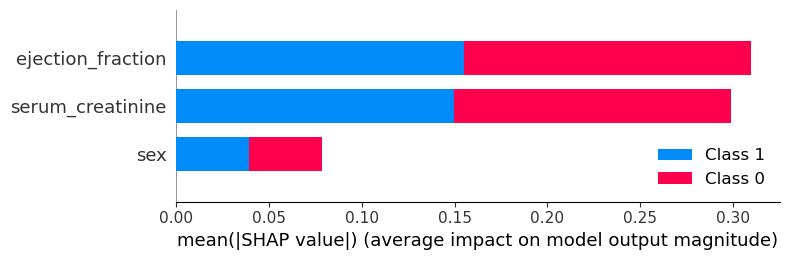

In [45]:
shap.summary_plot(shap_values_train, X_train_feat_sel,plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


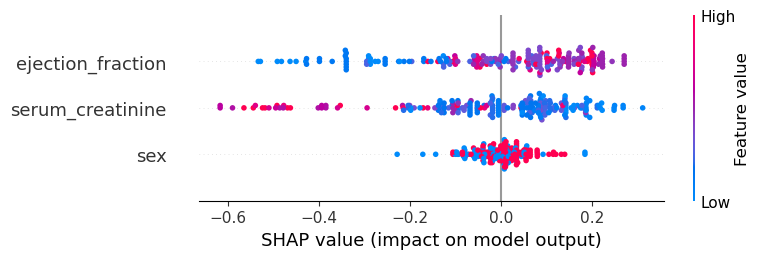

In [46]:
shap.summary_plot(shap_values_train[0], df_X_train_featsel,plot_type="dot")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


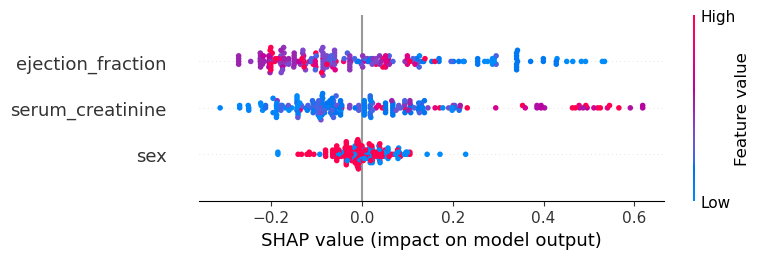

In [48]:
shap.summary_plot(shap_values_train[1], df_X_train_featsel,plot_type="dot")

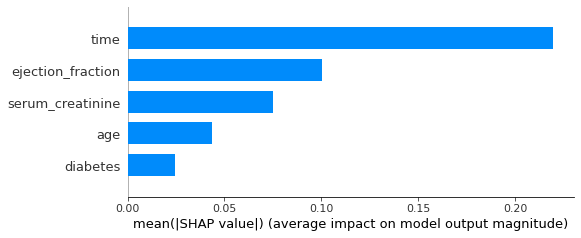

In [20]:
shap.summary_plot(shap_values_train[1], X_train_feat_sel,plot_type="bar")

In [21]:
X_train_feat_sel.head()

,age,ejection_fraction,serum_creatinine,time,diabetes
186,50.0,50,0.6,172,0
258,45.0,25,0.8,230,1
104,60.0,50,2.3,87,0
161,45.0,35,0.8,121,0
263,68.0,60,1.0,237,1


In [22]:
#local explainability
##########################################################
y_pred_test= extratree_clf.predict(df_X_test_featsel)
print('y_pred',y_pred_test)
print('y_test',y_test)

y_pred [0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0]
y_test [0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1
 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0]


In [23]:
y_pred_train = extratree_clf.predict(df_X_train_featsel)
print('y_pred_train',y_pred_train)
print('y_train',y_train)

y_pred_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
y_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [24]:
explainer_test=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))
shap_values_test=explainer_test.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))


 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling init() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling fit() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling transform() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling init() from Category_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling fit() from Category_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling transform() from Category_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling init() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling fit() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling transform() from Numeric_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling init() from Category_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling fit() from Category_Imputer

 Fri Sep  3 07:32:23 2021 >>>>>>>>Calling transform() from Category_Imputer


In [25]:
np.shape(shap_values_test)

(2, 90, 5)

In [26]:
#True negative instance
index_TN_shap=0
print(df_X_test_featsel.iloc[index_TN_shap])
print(X_test_feat_sel.iloc[index_TN_shap])
print('Actual Label:', y_test[index_TN_shap])
print('Predicted Label:', y_pred_test[index_TN_shap])
choosen_instance_tn=df_X_test_featsel.iloc[index_TN_shap]

age                  0.218182
ejection_fraction    0.347826
serum_creatinine     0.018182
time                 0.377698
diabetes             0.000000
Name: 0, dtype: float64
age                   52
ejection_fraction     30
serum_creatinine     0.7
time                 112
diabetes               0
Name: 146, dtype: object
Actual Label: 0
Predicted Label: 0


In [27]:
shap_values_test_tn = explainer_test.shap_values(choosen_instance_tn)
shap.force_plot(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

In [28]:
shap.initjs()

In [29]:
shap_values_test_tn = explainer_test.shap_values(choosen_instance_tn)
shap.force_plot(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

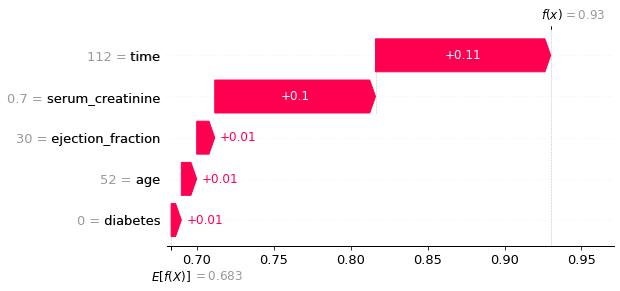

In [30]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

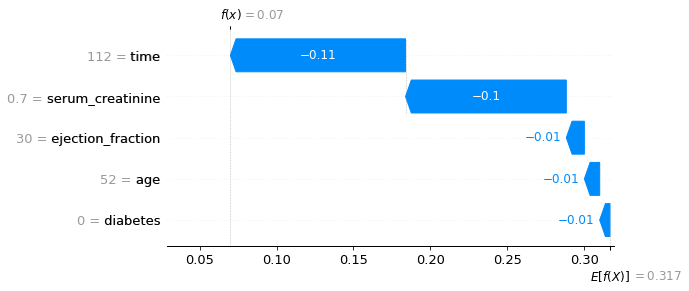

In [31]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test_tn[1], X_test_feat_sel.iloc[index_TN_shap])

In [32]:
index_TP_shap=2
print(df_X_test_featsel.iloc[index_TP_shap])
print(X_test_feat_sel.iloc[index_TP_shap])
print('Actual Label:', y_test[index_TP_shap])
print('Predicted Label:', y_pred_test[index_TP_shap])
choosen_instance_tp=df_X_test_featsel.iloc[index_TP_shap]

age                  0.636364
ejection_fraction    0.521739
serum_creatinine     0.618182
time                 0.010791
diabetes             0.000000
Name: 2, dtype: float64
age                  75
ejection_fraction    38
serum_creatinine      4
time                 10
diabetes              0
Name: 10, dtype: object
Actual Label: 1
Predicted Label: 1


In [33]:
shap_values_test_tp = explainer_test.shap_values(choosen_instance_tp)
shap.force_plot(explainer_test.expected_value[1], shap_values_test_tp[1], X_test_feat_sel.iloc[index_TP_shap])

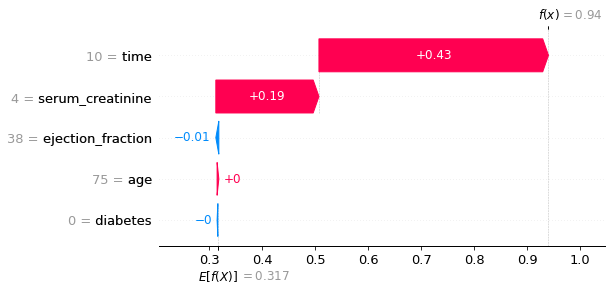

In [34]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test_tp[1], X_test_feat_sel.iloc[index_TP_shap])

In [35]:
index_TN_shap_train = 1
print(df_X_train_featsel.iloc[index_TN_shap_train])
print(X_train_feat_sel.iloc[index_TN_shap_train])
print('Actual Label:', y_train[index_TN_shap_train])
print('Predicted Label:', y_pred_train[index_TN_shap_train])
choosen_instance_tn_train=df_X_train_featsel.iloc[index_TN_shap_train]

age                  0.090909
ejection_fraction    0.153846
serum_creatinine     0.033708
time                 0.824818
diabetes             1.000000
Name: 1, dtype: float64
age                   45
ejection_fraction     25
serum_creatinine     0.8
time                 230
diabetes               1
Name: 258, dtype: object
Actual Label: 0
Predicted Label: 0


In [36]:
shap_values_tn_train = explainer_train.shap_values(choosen_instance_tn_train)
shap.force_plot(explainer_train.expected_value[1], shap_values_tn_train[1], choosen_instance_tn_train)

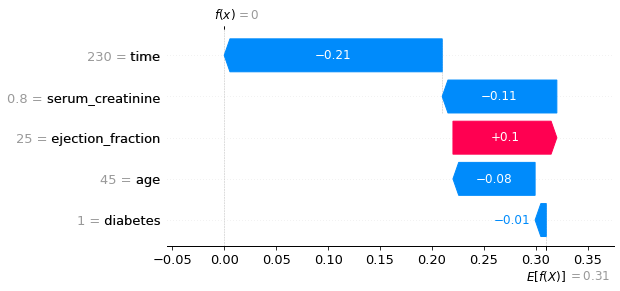

In [38]:
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_tn_train[1], X_train_feat_sel.iloc[index_TN_shap_train])

In [39]:
index_TP_shap_train = 7
print(df_X_train_featsel.iloc[index_TP_shap_train])
print(X_train_feat_sel.iloc[index_TP_shap_train])
print('Actual Label:', y_train[index_TP_shap_train])
print('Predicted Label:', y_pred_train[index_TP_shap_train])
choosen_instance_tp_train=X_train_feat_sel.iloc[index_TP_shap_train]

age                  0.909091
ejection_fraction    0.384615
serum_creatinine     0.179775
time                 0.014599
diabetes             0.000000
Name: 7, dtype: float64
age                   90
ejection_fraction     40
serum_creatinine     2.1
time                   8
diabetes               0
Name: 5, dtype: object
Actual Label: 1
Predicted Label: 1


In [40]:
shap_values_tp_train = explainer_train.shap_values(choosen_instance_tp_train)
shap.force_plot(explainer_train.expected_value[1], shap_values_tp_train[1], X_train_feat_sel.iloc[index_TP_shap_train])

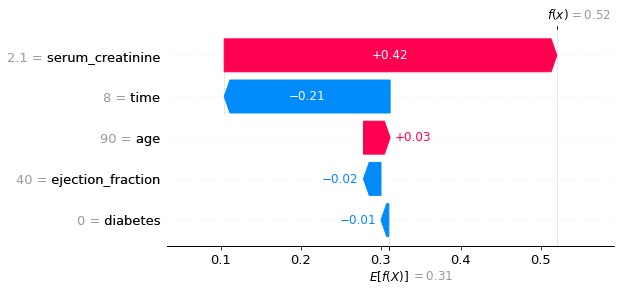

In [41]:
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_tp_train[1], X_train_feat_sel.iloc[index_TP_shap_train])